# Process
1. Prepped bouy data by getting just the period and amplitude for each sample.  This data is saved as period_amp.csv


In [1]:
import numpy as np
import wave_model as wm
import matplotlib.pyplot as plt
from scipy import signal
waves_in = np.loadtxt('data/period_amp.csv',delimiter=',')

Use wave model to simulate additional wave properties for each wave sampled and save results to new file.
1.	Using the Nantucket buoy data from problem set #2, calculate the value of the Lagrangian surface (z=0) Stokes drift for the entire 1-year record.   

In [2]:
#new array: measured_period,measured_amp,horiz,vert,pressure
depth = 75
calculated_wave = []
wave_out = open('data/drift_out.csv','w')
for w in waves_in:
    #solve wave and get some basic properties
    my_wave = wm.wave_solver(w[0],depth,w[1])
    wave_row = w

    #stokes drift at z = 0
    wave_row = np.append(wave_row,my_wave.stokes_drift(0))
    
    #write to array
    write_line = ",".join(map(str, wave_row))
    wave_out.write(write_line+'\n')
    calculated_wave.append(wave_row)
    
#save to new file
wave_out.close()

Read in simulated data and transpose for visualization.  Create measurments array as an index of data:

In [3]:
read_waves = np.loadtxt('data/drift_out.csv',delimiter=',',usecols = (0,1,2))
read_waves = read_waves.transpose()

import array
measurements = []
for i in range(0,len(read_waves[2])):
    measurements.append(i)

 Make a plot of this quantity as a function of time.  Discuss under what conditions, the surface stokes drift is highest.   As in problem set #2, assume the depth is 75m and that the wave amplitude (a) is half the reported significant wave height.

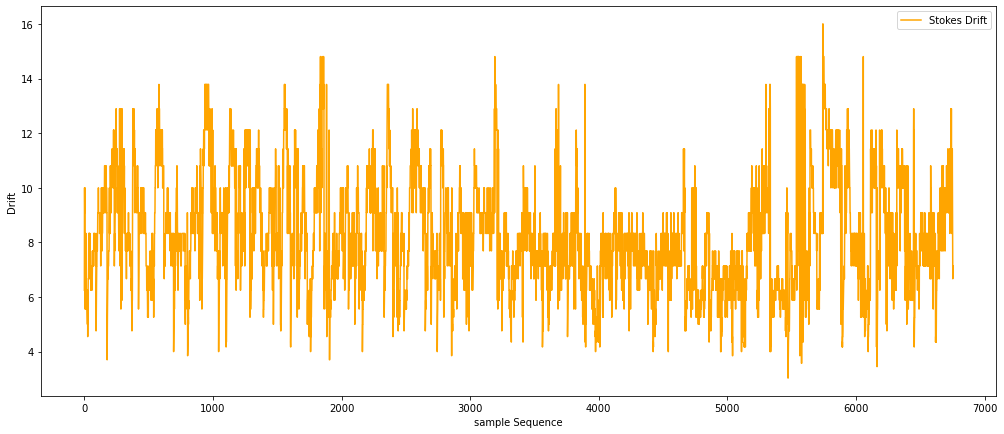

In [4]:
fig, (axs1) = plt.subplots(1, 1,figsize=(14, 6))
fig.tight_layout(h_pad=5,w_pad=5)

titles =["langrangian stokes drift at Z=0"]
colors = ["orange"]
labels=["Stokes Drift"]
    
i=0
for axs in fig.get_axes():
    axs.plot(measurements,read_waves[i],color=colors[i],label=labels[i])
    axs.set(xlabel="sample Sequence", ylabel="Drift")
    axs.autoscale()
    axs.legend(loc='upper right')
    i+=1
    
plt.show()

2.	Calculate the depth-integrated mass flux for a wave with a height of 1m (a = 0.5m) and wave period of 15s as it propagates from deep water to a depth of 5m.  Include shoaling (as in problem set #3) in your calculation.  Discuss how the resulting depth averaged current varies with depth.  Given that there cannot be a mean flow through the coastline, what are the implications for the across-shelf circulation.  What might a Eulerian current meter at a depth of 10m measure?

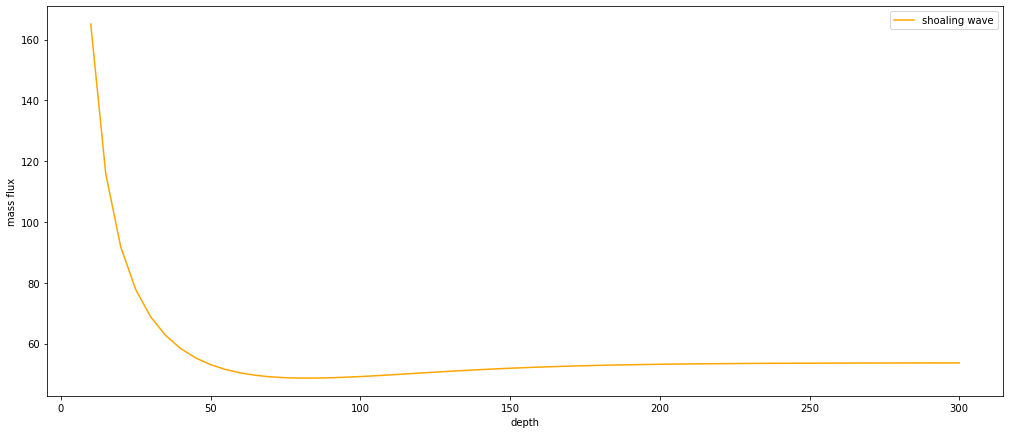

In [5]:
mass_wave = wm.wave_solver(15,300,0.5)
depths=np.arange(300,5,-5)

mass_fluxes=[]
for depth in depths:
    mass_fluxes.append(mass_wave.integrated_mass_flux(depth))

fig, (axs1) = plt.subplots(1, 1,figsize=(14, 6))
fig.tight_layout(h_pad=5,w_pad=5)

titles =["integrated mass flux"]
colors = ["orange"]
labels=["shoaling wave"]
    
i=0
for axs in fig.get_axes():
    axs.plot(depths,mass_fluxes,color=colors[i],label=labels[i])
    axs.set(xlabel="depth", ylabel="mass flux")
    axs.autoscale()
    axs.legend(loc='upper right')
    i+=1
    
plt.show()

3.	The Lagrangian Stokes drift velocity profile was presented in class.
a.	Derive an expression for the Stokes drift velocity profile [Us(z)] in terms of the sea surface frequency spectrum [S(f)].
b.	Use this expression in conjunction with the Chesapeake Bay Data pressure data to calculate the Stokes drift velocity profile.  For these calculations, only consider frequencies between (1/10 and 1 Hz) and assume that S = Spp, when pressure is measured in decibars.
c.	How does this profile compare with the estimate from linear wave theory based on the dominant wave period. 
6

For HW 5, question 3 part B it states “assume that Shh = Spp, when pressure is measured in decibars.”  So here you are assuming that the pressure time series is really a sea surface elevation time series.  You are asked to derive an expression for the stokes drift based on the sea surface elevation spectrum (Shh). This expression will represent the contribution of waves of different frequencies to the Lagrangian stokes drift profile. This expression can be integrated across frequencies to give one value of stokes for a given depth.   Different frequencies decay differently with depth, so the energy distribution as a function of frequency matters and you won’t get exactly the same profile as with the dominant period (but it should be close). The spectrum at high frequencies is noise and at low frequencies is not wave motions, so the question is asking you to integrate only the frequencies in the wave band (e.g. 1/10 to 1 Hz).  So your plot should have velocity on the x-axis and depth on the y-axis.

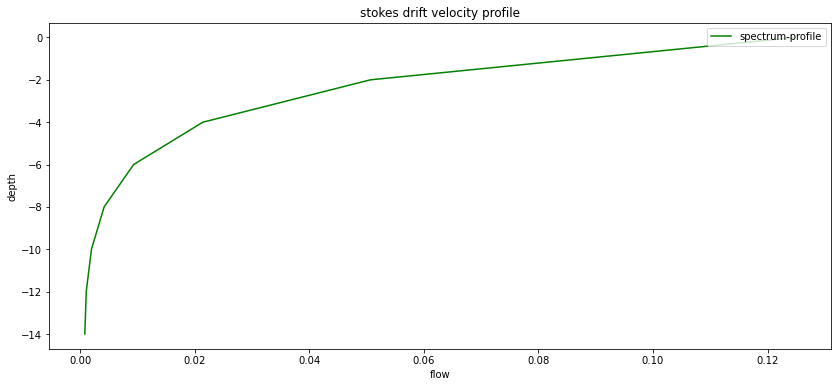

In [13]:
from scipy import stats
CB_data = np.loadtxt('data/ADV_data_CB_out1.csv',delimiter=',',skiprows=1)
#CB: water depth is 14m
#data was collected 1.8m below the mean sea surface (z = -1.8m)
#data order: dn,P,u,v,w
CB_data = CB_data.transpose()
depths=np.arange(10,0,-1)

fig, (axs1) = plt.subplots(1, 1,figsize=(14, 6))

titles =["stokes drift velocity profile"]
colors = ["green"]
labels=["spectrum-profile"]    

pf, CB_Pxx_press = signal.welch(CB_data[1], 32, nperseg=1024)
CB_Pxx_surface = CB_Pxx_press #sea surface height above sensor is equal to pressure measured in decibars


trim_f = []
trim_surf = []
for i in range(len(pf)):
    if pf[i] > 0.1 and pf[i] < 1:
        trim_f.append(pf[i])
        trim_surf.append(CB_Pxx_surface[i])

#psd = np.row_stack([trim_f,trim_surf])

flow_depths = [0,-2,-4,-6,-8,-10,-12,-14]
flows = []
for depth in flow_depths:
    drift_spectrum = wm.integrated_stoke_drift(trim_surf,trim_f,14,depth)
    flows.append(np.sum(drift_spectrum))


i=0
for axs in fig.get_axes():
    axs.plot(flows,flow_depths,color=colors[i],label=labels[i])
    axs.set(ylabel="depth", xlabel="flow")
    axs.autoscale()
    axs.legend(loc='upper right')
    axs.set_title(titles[i])
    i+=1
    
    
plt.show()

# Conclusions

